In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import optimize, stats

C:\Users\miche\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Patient of interest

In [2]:
# read in patient one dataset
df_patient_hr = pd.read_csv('hrv_patient1.csv')
df_patient_hr['timestamp'] = pd.to_datetime(df_patient_hr['timestamp'])
df_patient_hr.set_index('timestamp', inplace=True)

In [3]:
df_patient_hr

,HRV_5min
timestamp,
2009-03-04 11:00:00,87.453601
2009-03-04 11:05:00,80.410900
2009-03-04 11:10:00,70.544131
2009-03-04 11:15:00,48.572720
2009-03-04 11:20:00,42.948152
...,...
2009-03-05 07:45:00,43.358781
2009-03-05 07:50:00,41.196692
2009-03-05 07:55:00,54.715109


In [4]:
# check to make sure there are no null values
df_patient_hr.isnull().sum()

HRV_5min    0
dtype: int64

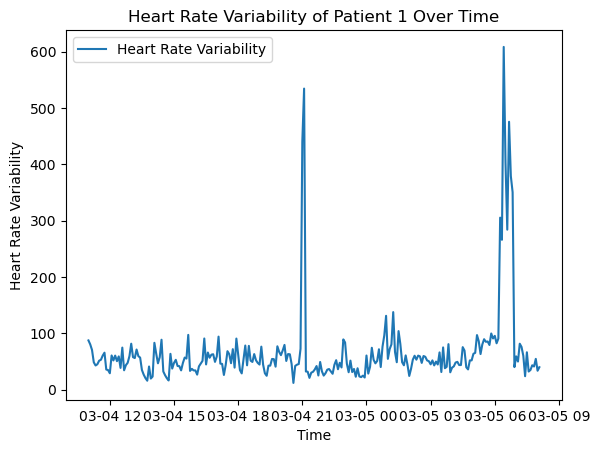

In [5]:
# visualize the time series
plt.plot(df_patient_hr['HRV_5min'], label='Heart Rate Variability')
plt.xlabel('Time')
plt.ylabel('Heart Rate Variability')
plt.legend()
plt.title('Heart Rate Variability of Patient 1 Over Time')
plt.show();

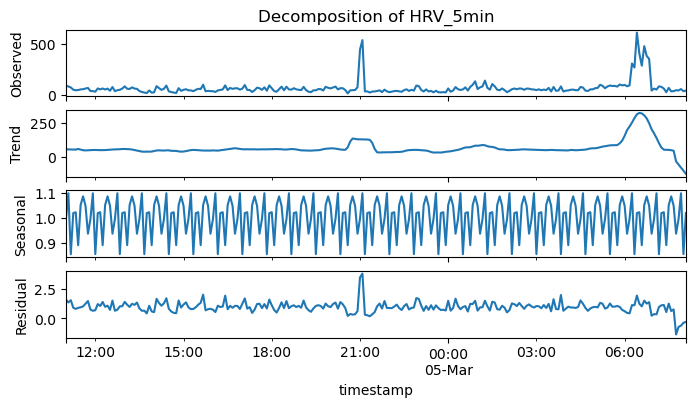

In [6]:
# checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
decomp1 = seasonal_decompose(df_patient_hr['HRV_5min'], period=10, model='multiplicative', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV_5min')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

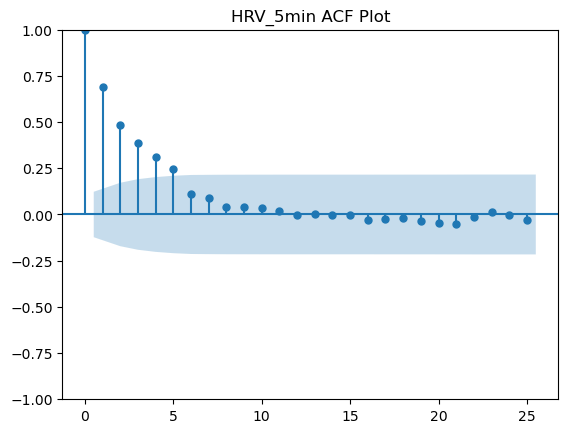

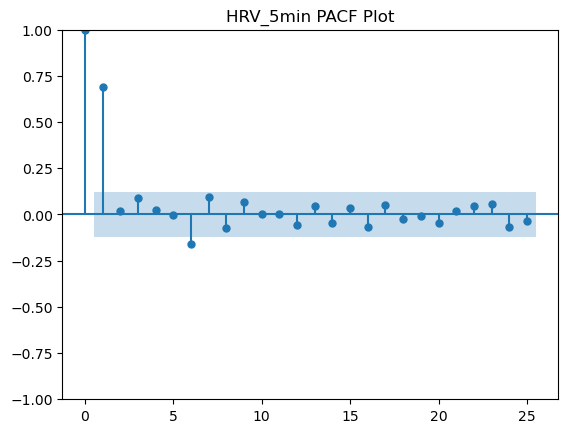

In [7]:
# plot of original dataset

# Autocorrelation Function
# This is used to determine the appropriate lag

series = df_patient_hr['HRV_5min']
plot_acf(series, title = 'HRV_5min ACF Plot')
plt.show();

# plot partial autocorrelation function (PACF)
plot_pacf(series, title = 'HRV_5min PACF Plot')
plt.show();

# AR Model

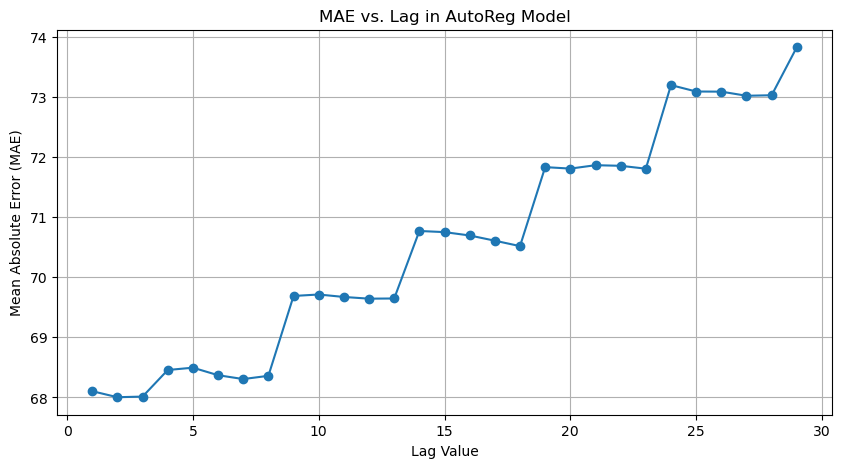

In [8]:
# define a range of lags to test
lag_values = range(1, 30)
mae_scores = []

# loop through different lag values
for lag in lag_values:
    df_patient_hr = pd.read_csv('hrv_patient1.csv')
    df_patient_hr['timestamp'] = pd.to_datetime(df_patient_hr['timestamp'])
    df_patient_hr.set_index('timestamp', inplace=True)

    # create lag features
    for i in range(1, lag+1):
        df_patient_hr[f'Lag {i}'] = df_patient_hr['HRV_5min'].shift(i)

    df_patient_hr = df_patient_hr.dropna()
    
    # split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
    train_size = int(.8 * len(df_patient_hr))
    train_data = df_patient_hr[:train_size]
    test_data = df_patient_hr[train_size:]

    # put the y feature in arrays
    y_train = np.array(train_data['HRV_5min']).reshape(-1,1)
    y_test = np.array(test_data['HRV_5min']).reshape(-1,1)
    
     # fit AR model with different lags
    ar_model = AutoReg(y_train, lags=lag, trend='c')
    ar_results = ar_model.fit()
    
    # make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # comptute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

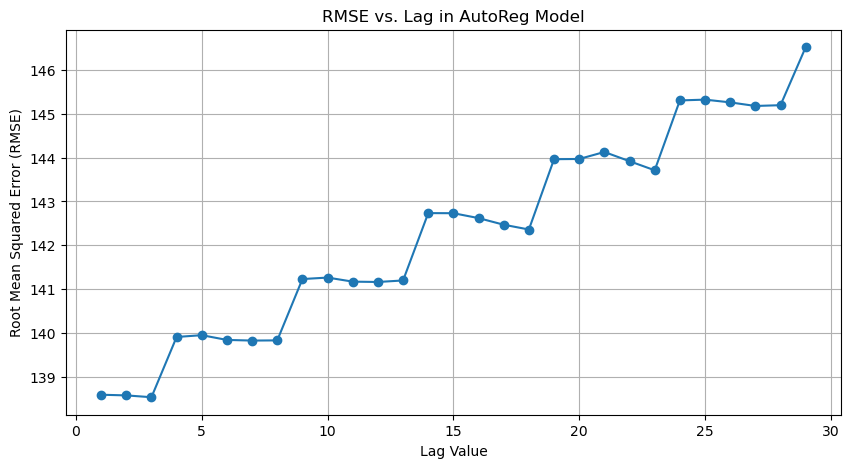

In [9]:
# define a range of lags to test
lag_values = range(1, 30)
rmse_scores = []

# loop through different lag values
for lag in lag_values:
    df_patient_hr = pd.read_csv('hrv_patient1.csv')
    df_patient_hr['timestamp'] = pd.to_datetime(df_patient_hr['timestamp'])
    df_patient_hr.set_index('timestamp', inplace=True)

    # create lag features
    for i in range(1, lag+1):
        df_patient_hr[f'Lag {i}'] = df_patient_hr['HRV_5min'].shift(i)

    df_patient_hr = df_patient_hr.dropna()
    
    # split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
    train_size = int(.8 * len(df_patient_hr))
    train_data = df_patient_hr[:train_size]
    test_data = df_patient_hr[train_size:]

    # put the y feature in arrays
    y_train = np.array(train_data['HRV_5min']).reshape(-1,1)
    y_test = np.array(test_data['HRV_5min']).reshape(-1,1)
    
     # fit AR model with different lags
    ar_model = AutoReg(y_train, lags=lag, trend='c')
    ar_results = ar_model.fit()
    
    
    # make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
     
    # compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)

# plot RMSE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

## Manually

In [10]:
# lag chosen
lag = 3

df_patient_hr = pd.read_csv('hrv_patient1.csv')
df_patient_hr['timestamp'] = pd.to_datetime(df_patient_hr['timestamp'])
df_patient_hr.set_index('timestamp', inplace=True)

# create lag features
for i in range(1, lag+1):
    df_patient_hr[f'Lag {i}'] = df_patient_hr['HRV_5min'].shift(i)

df_patient_hr = df_patient_hr.dropna()
    
# split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
train_size = int(.8 * len(df_patient_hr))
train_data = df_patient_hr[:train_size]
test_data = df_patient_hr[train_size:]

# put the y feature in arrays
y_train = np.array(train_data['HRV_5min']).reshape(-1,1)
y_test = np.array(test_data['HRV_5min']).reshape(-1,1)

# define X train
X_train = train_data.drop(columns=["HRV_5min"])
X_train = np.column_stack((np.ones(len(X_train)), X_train))

# fit the model using OLS
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
print("Model coefficients:", w)

# initialize predictions
y_pred = []
last_vals = np.array(train_data['HRV_5min'].iloc[-lag:].values[::-1])

# add constant term to last_vals for prediction
last_vals_with_const = np.concatenate([[1], last_vals])

for i in range(len(y_test)):
    # predict next value
    next_val = np.dot(last_vals_with_const, w)
    y_pred.append(next_val)
    
    # update last_vals
    last_vals = np.roll(last_vals, -1)
    last_vals[-1] = next_val
    last_vals_with_const = np.concatenate([[1], last_vals])

Model coefficients: [[33.29846201]
 [ 0.60356353]
 [-0.31456691]
 [ 0.10529452]]


In [11]:
# function to find the roots to look at stationary assumption
def find_ar_roots(ar_coeffs):
    # Make sure ar_coeffs is 1D
    ar_coeffs_1d = ar_coeffs.flatten() if ar_coeffs.ndim > 1 else ar_coeffs
    
    # Create the polynomial coefficients (note the negative sign for AR coeffs)
    poly_coeffs = np.concatenate([[1], -1 * ar_coeffs_1d])
    
    # Find the roots
    roots = np.roots(poly_coeffs)
    
    return roots

# coefficients of the model
ar_coeffs = w[1:]

# roots of the model
roots = find_ar_roots(ar_coeffs)
print(abs(roots))

[0.43599023 0.4914332  0.4914332 ]


In [12]:
# put predictions into a data frame for plotting purposes
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV_5min': y_pred})
pred_data.set_index('Time', inplace=True)
pred_data.head()

,pred HRV_5min
Time,
2009-03-05 03:55:00,[73.35649285047586]
2009-03-05 04:00:00,[53.47156993600047]
2009-03-05 04:05:00,[38.86336702379796]
2009-03-05 04:10:00,[64.84547820270625]
2009-03-05 04:15:00,[60.17469512637516]


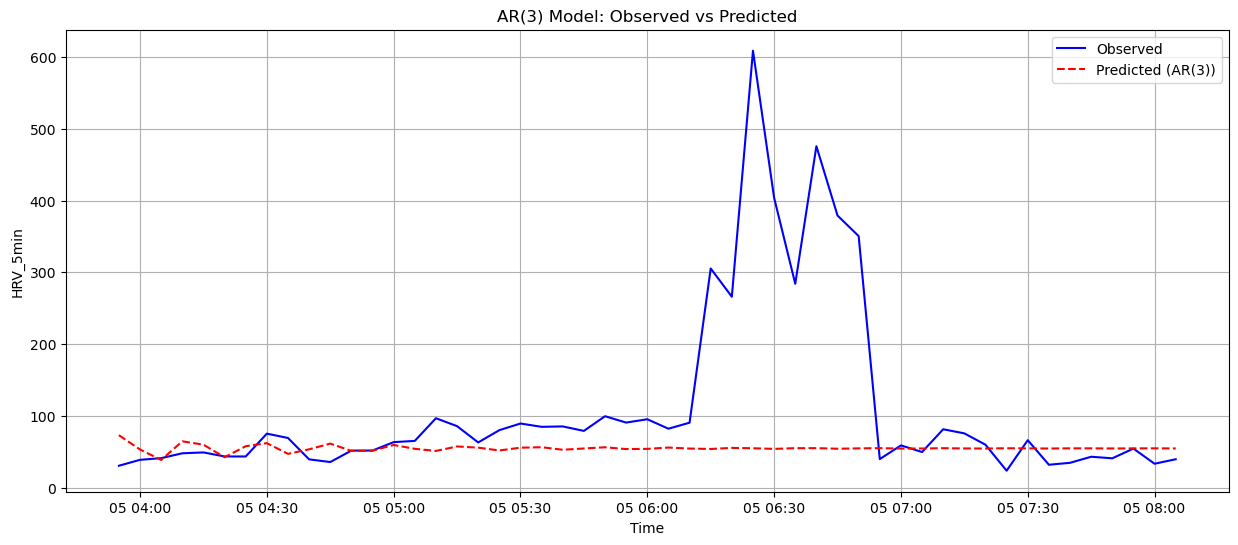

In [13]:
# plot observed versus predicted
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data['HRV_5min'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV_5min'], 'r--', label='Predicted (AR(3))')
plt.legend()
plt.title('AR(3) Model: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV_5min')
plt.grid(True)
plt.show()

In [14]:
# compute mae and rmse
mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 67.91
Root Mean Squared Error: 138.67


# MA model

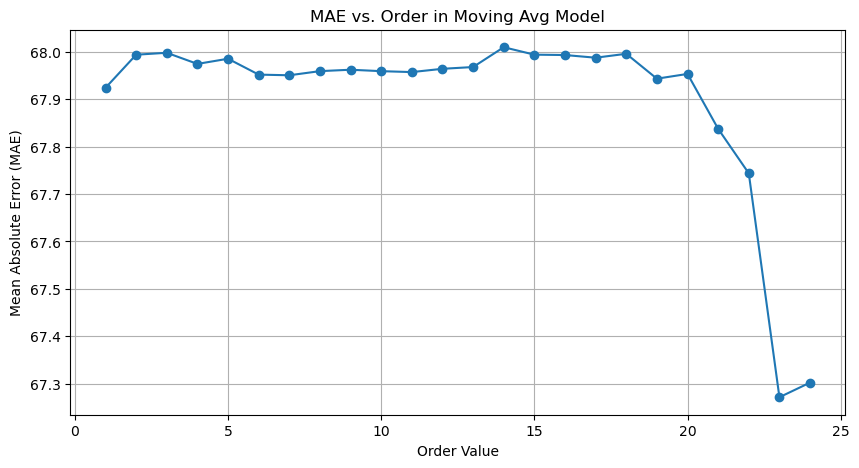

In [15]:
# define a range of orders to test
o_values = range(1, 25)
mae_scores = []

# loop through different order values
for o in o_values:
    df_patient_hr = pd.read_csv('hrv_patient1.csv')
    df_patient_hr['timestamp'] = pd.to_datetime(df_patient_hr['timestamp'])
    df_patient_hr.set_index('timestamp', inplace=True)

    # create lag features
    for i in range(1, lag+1):
        df_patient_hr[f'Lag {i}'] = df_patient_hr['HRV_5min'].shift(i)

    df_patient_hr = df_patient_hr.dropna()
    
    # split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
    train_size = int(.8 * len(df_patient_hr))
    train_data = df_patient_hr[:train_size]
    test_data = df_patient_hr[train_size:]

    # put the y feature in arrays
    y_train = np.array(train_data['HRV_5min']).reshape(-1,1)
    y_test = np.array(test_data['HRV_5min']).reshape(-1,1)
    
    ma_model = ARIMA(y_train, order=(0,0,o))
    ma_results = ma_model.fit()
    
    # make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # compute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(o_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

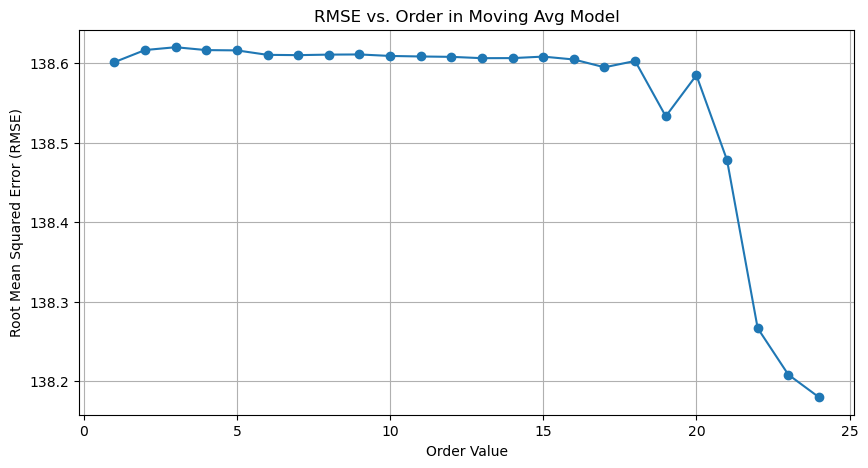

In [16]:
# define a range of orders to test
o_values = range(1, 25)
rmse_scores = []

# loop through different order values
for o in o_values:
    df_patient_hr = pd.read_csv('hrv_patient1.csv')
    df_patient_hr['timestamp'] = pd.to_datetime(df_patient_hr['timestamp'])
    df_patient_hr.set_index('timestamp', inplace=True)

    # create lag features
    for i in range(1, lag+1):
        df_patient_hr[f'Lag {i}'] = df_patient_hr['HRV_5min'].shift(i)

    df_patient_hr = df_patient_hr.dropna()
    
    # split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
    train_size = int(.8 * len(df_patient_hr))
    train_data = df_patient_hr[:train_size]
    test_data = df_patient_hr[train_size:]

    # put the y feature in arrays
    y_train = np.array(train_data['HRV_5min']).reshape(-1,1)
    y_test = np.array(test_data['HRV_5min']).reshape(-1,1)
    
    ma_model = ARIMA(y_train, order=(0,0,o))
    ma_results = ma_model.fit()
    
    # make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # compute rmse
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)


# plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(o_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

## Manually

In [17]:
# order chosen
order = 23

df_patient_hr = pd.read_csv('hrv_patient1.csv')
df_patient_hr['timestamp'] = pd.to_datetime(df_patient_hr['timestamp'])
df_patient_hr.set_index('timestamp', inplace=True)

# create lag features
for i in range(1, lag+1):
    df_patient_hr[f'Lag {i}'] = df_patient_hr['HRV_5min'].shift(i)

df_patient_hr = df_patient_hr.dropna()
    
# split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
train_size = int(.8 * len(df_patient_hr))
train_data = df_patient_hr[:train_size]
test_data = df_patient_hr[train_size:]

# put the y feature in arrays
y_train = np.array(train_data['HRV_5min']).reshape(-1,1)
y_test = np.array(test_data['HRV_5min']).reshape(-1,1)
    

# calculate the error terms (residuals)
def ma_errors(params, y, q):
    """
    Calculate residuals for MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    # define variables
    intercept = params[0]  
    theta = params[1:]  
    n = len(y)
    errors = np.zeros(n)
    
    # initialize past errors
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
        # make prediction
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
        
    return errors

# calculate the log-likelihood for MA(q) model
def ma_log_likelihood(params, y, q):
    """
    Calculate the log-likelihood for MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    # define variables
    intercept = params[0]
    theta = params[1:]
    n = len(y)
    errors = np.zeros(n)
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
        # make prediction
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
    
    # calculate log-likelihood (assuming errors are normally distributed)
    sigma2 = np.var(errors)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(errors**2) / sigma2
    
    return -log_likelihood

# fit MA model using MLE
def fit_ma_mle(y_train, q):
    """
    Fit MA(q) model with intercept using Maximum Likelihood Estimation
    y_train: training data for y
    q: order of the model
    """
    # initialize parameters (intercept and theta parameters)
    initial_intercept = np.mean(y_train)
    initial_theta = np.zeros(q)
    initial_params = np.concatenate(([initial_intercept], initial_theta))
    
    # use optimization to find the best parameters
    result = optimize.minimize(ma_log_likelihood, initial_params, args=(y_train, q,), 
                             method='L-BFGS-B')
    return result.x

# predict using MA model
def predict_ma(params, y_test_len, training_errors, q):
    """
    Make predictions using MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters
    y_test_len: number of steps to predict
    training_errors: last q error terms from training data
    q: order of the model
    """
    # define intercept and theta
    intercept = params[0]
    theta = params[1:]
    
    # initialize predictions array
    predictions = np.zeros(y_test_len)
    # start with last q error terms from training
    past_errors = np.array(training_errors[:q])
    
    for t in range(y_test_len):
        # predictions
        predictions[t] = intercept + np.sum(theta * past_errors)
        new_error = 0
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = new_error
        
    return predictions

# fit MA(q) and make predictions
def run_ma_model_mle(train_data, test_data, q):
    # Convert Series to numpy arrays
    y_train = np.array(train_data['HRV_5min'])
    
    # fit MA(q) model with intercept using MLE
    params = fit_ma_mle(y_train, q)
    intercept = params[0]
    theta = params[1:]
    
    # print coefficients
    print("Coefficients:")
    print(f"Intercept: {intercept:.6f}")
    for i, coef in enumerate(theta):
        print(f"MA({i+1}): {coef:.6f}")
    
    # calculate errors from training data
    training_errors = ma_errors(params, y_train, q)
    
    # make predictions
    y_pred = predict_ma(params, len(test_data), training_errors, q)
    
    # put predictions into dataframe format
    pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV_5min': y_pred})
    pred_data.set_index('Time', inplace=True)
    
    return pred_data, params

In [18]:
# run ma model
pred_data, theta = run_ma_model_mle(train_data, test_data, order)
pred_data.head()

Coefficients:
Intercept: 55.213402
MA(1): 0.607800
MA(2): 0.032315
MA(3): -0.029359
MA(4): -0.026749
MA(5): -0.047951
MA(6): -0.126502
MA(7): -0.023730
MA(8): -0.015673
MA(9): -0.026441
MA(10): -0.022784
MA(11): -0.002635
MA(12): -0.027514
MA(13): -0.063451
MA(14): -0.025554
MA(15): -0.014834
MA(16): -0.073662
MA(17): -0.054163
MA(18): -0.002912
MA(19): -0.038058
MA(20): -0.061168
MA(21): -0.115327
MA(22): -0.050396
MA(23): -0.008533


,pred HRV_5min
Time,
2009-03-05 03:55:00,49.859571
2009-03-05 04:00:00,59.139354
2009-03-05 04:05:00,57.249572
2009-03-05 04:10:00,60.856936
2009-03-05 04:15:00,57.740710


In [19]:
# function to get roots for ma model
def find_ma_roots(ma_coeffs):
    # create the polynomial coefficients (note the negative sign for MA coeffs)
    poly_coeffs = np.concatenate([[1], -1 * ma_coeffs])
    
    # find the roots
    roots = np.roots(poly_coeffs)
    
    return roots

# coefficients of the ma model
ma_coeffs = theta[1:]

# roots of the ma model
roots = find_ma_roots(ma_coeffs)
print(abs(roots))

[0.99075775 0.99075775 0.97206231 0.97206231 0.93016522 0.93016522
 0.91103189 0.91103189 0.91142554 0.91142554 0.89797352 0.89797352
 0.81098649 0.81098649 0.83649921 0.84486337 0.84486337 0.85447663
 0.85447663 0.84135851 0.84135851 0.30696637 0.30696637]


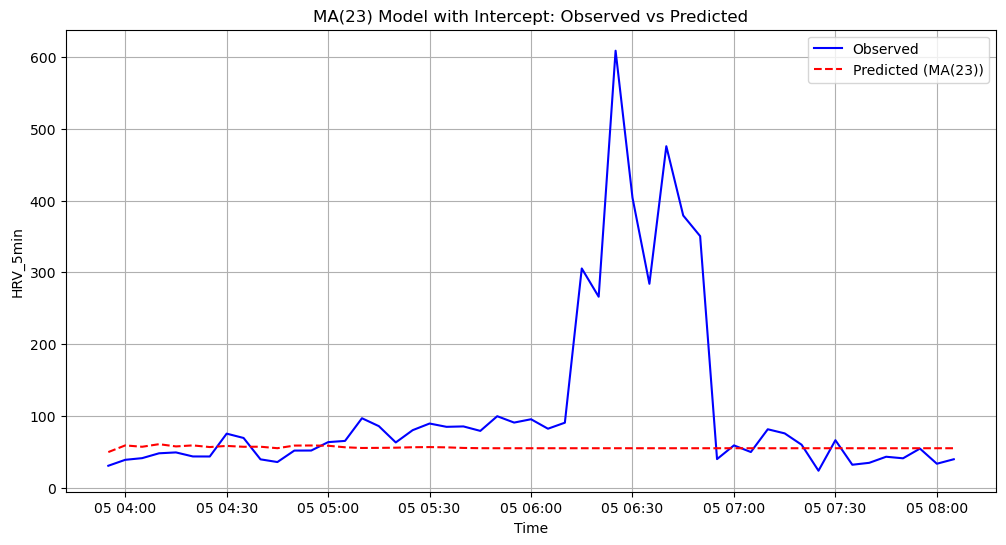

In [20]:
# plot observed versus predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HRV_5min'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV_5min'], 'r--', label='Predicted (MA(23))')
plt.legend()
plt.title('MA(23) Model with Intercept: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV_5min')
plt.grid(True)
plt.show()

In [21]:
# compute mae and rmse
mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 67.79
Root Mean Squared Error: 138.42
